# Harry Potter Face Recognition Pipeline

This notebook provides a unified pipeline for image processing and face recognition using MobileNetV2. It ensures that the same transformations are applied to all images, both during training and prediction.

## Pipeline Overview
1. Scrape images for each actor
2. Detect and crop faces with MTCNN
3. Preprocess images (resize, grayscale, normalization)
4. Split dataset into train/val/test
5. Train MobileNetV2 model
6. Predict on new images with identical preprocessing

In [ ]:
# Install required libraries
!pip install icrawler mtcnn Pillow opencv-python matplotlib tensorflow scikit-learn seaborn

## 1. Scrape Images for Each Actor
Images are downloaded from Google Images using icrawler.

In [1]:
import os
from icrawler.builtin import GoogleImageCrawler
actors = ["Daniel Radcliffe", "Emma Watson", "Rupert Grint", "Maggie Smith", "Michael Gambon", "Bonnie Wright", "Alan Rickman", "Helena Bonham Carter", "Tom Felton", "Evanna Lynch"]
data_dir = 'data'
source_dir = os.path.join(data_dir, 'source')
os.makedirs(source_dir, exist_ok=True)

In [ ]:
for actor in actors:
    search_query = f"{actor} Harry Potter"
    actor_dir = os.path.join(source_dir, actor.replace(" ", "_"))
    os.makedirs(actor_dir, exist_ok=True)
    print(f"Scraping images for: {search_query}")
    crawler = GoogleImageCrawler(storage={"root_dir": actor_dir})
    crawler.crawl(keyword=search_query, max_num=200, min_size=(128,128), file_idx_offset=0)

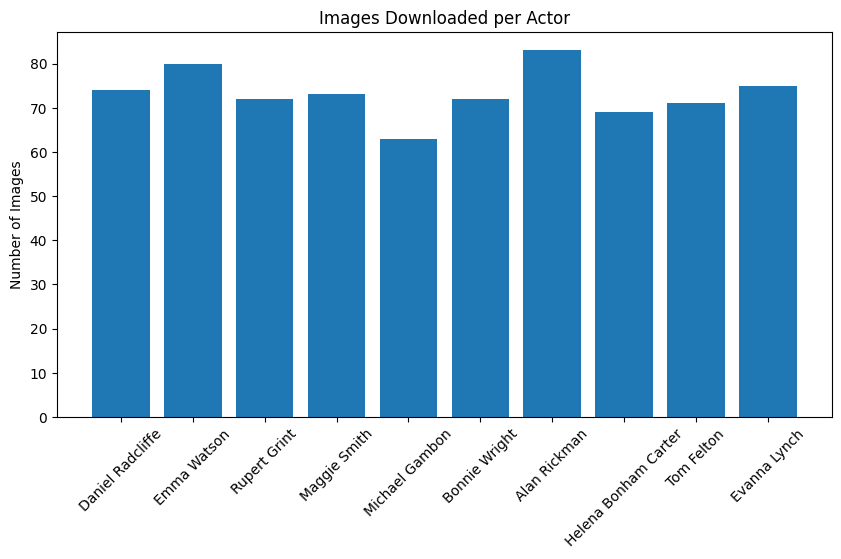

In [3]:
# Visualize number of images downloaded per actor
import matplotlib.pyplot as plt
import os

actor_counts = {}
for actor in actors:
    actor_dir = os.path.join("data/source", actor.replace(" ", "_"))
    if os.path.exists(actor_dir):
        count = len([f for f in os.listdir(actor_dir) if os.path.isfile(os.path.join(actor_dir, f))])
        actor_counts[actor] = count
    else:
        actor_counts[actor] = 0

plt.figure(figsize=(10,5))
plt.bar(actor_counts.keys(), actor_counts.values())
plt.xticks(rotation=45)
plt.ylabel('Number of Images')
plt.title('Images Downloaded per Actor')
plt.show()

## 2. Unified Image Preprocessing Pipeline
This function will be used for both training and prediction.

In [6]:
from mtcnn import MTCNN
from PIL import Image
import numpy as np
def preprocess_image(img_path, target_size=(224,224), to_grayscale=True):
    img = Image.open(img_path).convert('RGB')
    img_np = np.array(img)
    detector = MTCNN()
    faces = detector.detect_faces(img_np)
    if len(faces) != 1:
        return None  # Skip images with no/multiple faces
    x, y, w, h = faces[0]['box']
    expand_ratio = 0.4
    x_exp = max(int(x - w * expand_ratio), 0)
    y_exp = max(int(y - h * expand_ratio), 0)
    w_exp = min(int(w * (1 + 2 * expand_ratio)), img.width - x_exp)
    h_exp = min(int(h * (1 + 2 * expand_ratio)), img.height - y_exp)
    face_img = img.crop((x_exp, y_exp, x_exp + w_exp, y_exp + h_exp))
    if to_grayscale:
        face_img = face_img.convert('L')
    face_img = face_img.resize(target_size)
    img_np = np.array(face_img).astype(np.float32)
    return img_np

In [27]:
# Execute preprocessing for all images and save to preprocessed_dir
preprocessed_dir = os.path.join(data_dir, 'preprocessing')
for actor in actors:
    src_dir = os.path.join(source_dir, actor.replace(' ', '_'))
    dst_dir = os.path.join(preprocessed_dir, actor.replace(' ', '_'))
    os.makedirs(dst_dir, exist_ok=True)
    for img_name in os.listdir(src_dir):
        img_path = os.path.join(src_dir, img_name)
        img_np = preprocess_image(img_path)
        if img_np is not None:
            Image.fromarray(img_np.astype(np.uint8)).save(os.path.join(dst_dir, img_name))

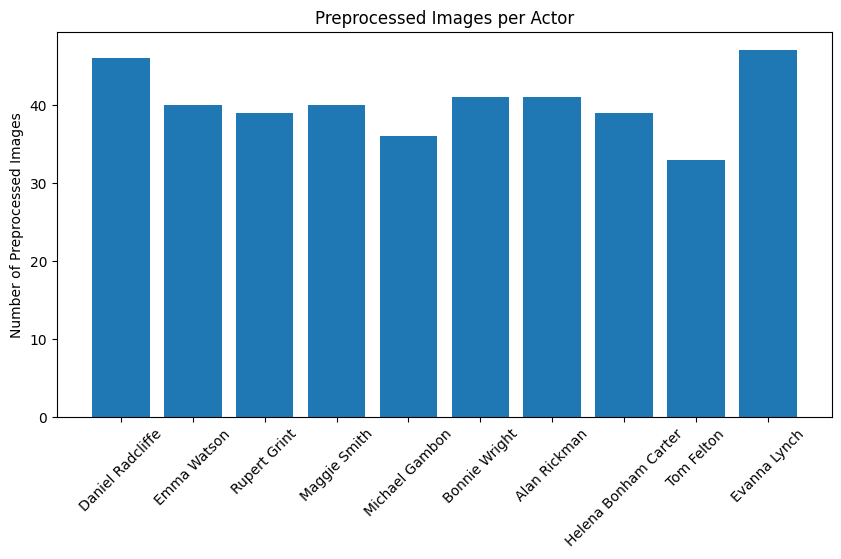

In [4]:
# Visualize number of preprocessed images per actor
preproc_counts = {}
for actor in actors:
    actor_dir = os.path.join("data/preprocessing", actor.replace(" ", "_"))
    if os.path.exists(actor_dir):
        count = len([f for f in os.listdir(actor_dir) if os.path.isfile(os.path.join(actor_dir, f))])
        preproc_counts[actor] = count
    else:
        preproc_counts[actor] = 0

plt.figure(figsize=(10,5))
plt.bar(preproc_counts.keys(), preproc_counts.values())
plt.xticks(rotation=45)
plt.ylabel('Number of Preprocessed Images')
plt.title('Preprocessed Images per Actor')
plt.show()

## 3. Preprocess and Split Dataset
Apply the unified preprocessing to all images and split into train/val/test.

In [53]:
import random
import shutil

def prepare_dataset():
    split_dirs = {'train': os.path.join(data_dir, 'train'), 'val': os.path.join(data_dir, 'val'), 'test': os.path.join(data_dir, 'test')}
    for split in split_dirs.values():
        shutil.rmtree(split)
        os.makedirs(split, exist_ok=True)
    for actor in actors:
        src_dir = os.path.join(preprocessed_dir, actor.replace(' ', '_'))
        images = [f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))]
        random.shuffle(images)
        n_total = len(images)
        n_val = 5
        n_test = 5
        splits = {
            'test': images[:n_test],
            'val': images[n_test:n_test+n_val],
            'train': images[n_test+n_val:]
        }
        for split, split_imgs in splits.items():
            split_actor_dir = os.path.join(split_dirs[split], actor.replace(' ', '_'))
            os.makedirs(split_actor_dir, exist_ok=True)
            for img_name in split_imgs:
                src_img_path = os.path.join(src_dir, img_name)
                # Instead of reprocessing, just copy the preprocessed image
                shutil.copy2(src_img_path, os.path.join(split_actor_dir, img_name))


In [54]:
prepare_dataset()

## 4. Load Datasets for Training
Use TensorFlow to load the processed images for model training.

In [8]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 56
train_ds = tf.keras.utils.image_dataset_from_directory('data/train', labels='inferred', label_mode='categorical', batch_size=BATCH_SIZE, image_size=IMG_SIZE, shuffle=True, seed=42)
val_ds = tf.keras.utils.image_dataset_from_directory('data/val', labels='inferred', label_mode='categorical', batch_size=BATCH_SIZE, image_size=IMG_SIZE, shuffle=False)
test_ds = tf.keras.utils.image_dataset_from_directory('data/test', labels='inferred', label_mode='categorical', batch_size=BATCH_SIZE, image_size=IMG_SIZE, shuffle=False)
class_names = train_ds.class_names

Found 302 files belonging to 10 classes.
Found 50 files belonging to 10 classes.
Found 50 files belonging to 10 classes.
Found 50 files belonging to 10 classes.
Found 50 files belonging to 10 classes.


In [56]:
from tensorflow.keras import layers
import tensorflow as tf

# Custom layer for adding random noise
class RandomNoise(layers.Layer):
    def __init__(self, stddev=0.05, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, inputs, training=None):
        if training:
            noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.stddev)
            return inputs + noise
        return inputs

# Custom layer for color jitter
class ColorJitter(layers.Layer):
    def __init__(self, brightness=0.2, contrast=0.2, saturation=0.2, **kwargs):
        super().__init__(**kwargs)
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation

    def call(self, inputs, training=None):
        if training:
            x = tf.image.random_brightness(inputs, max_delta=self.brightness)
            x = tf.image.random_contrast(x, lower=1-self.contrast, upper=1+self.contrast)
            x = tf.image.random_saturation(x, lower=1-self.saturation, upper=1+self.saturation)
            return x
        return inputs

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomShear(0.1),
    RandomNoise(stddev=0.02),
    ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1)
])

def augment_ds(ds):
    return ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)

train_ds_aug = augment_ds(train_ds)

## 5. Build and Train MobileNetV2 Model

In [57]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False
inputs = base_model.input
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(len(class_names), activation='softmax', kernel_regularizer=regularizers.l2(0.01))(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,926,154 (11.16 MB)

 Trainable params: 664,586 (2.54 MB)

 Non-trainable params: 2,261,568 (8.63 MB)

In [58]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint('best_mobilenetv2.keras', monitor='val_loss', save_best_only=True)
]
history = model.fit(train_ds_aug, validation_data=val_ds, epochs=100, callbacks=callbacks)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 754ms/step - accuracy: 0.1623 - loss: 10.7602 - val_accuracy: 0.2600 - val_loss: 9.5516 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 754ms/step - accuracy: 0.1623 - loss: 10.7602 - val_accuracy: 0.2600 - val_loss: 9.5516 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 557ms/step - accuracy: 0.3046 - loss: 9.6472 - val_accuracy: 0.2200 - val_loss: 9.4257 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 557ms/step - accuracy: 0.3046 - loss: 9.6472 - val_accuracy: 0.2200 - val_loss: 9.4257 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 558ms/step - accuracy: 0.3675 - loss: 9.1949 - val_accuracy: 0.2400 - val_loss: 9.2762 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 558ms/step - accuracy: 0.3675 - loss: 9.1949 - val_accuracy: 0.2400 - val_loss: 9.2762 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 548ms/step - accuracy: 0.4536 - loss: 8.8571 - val_a

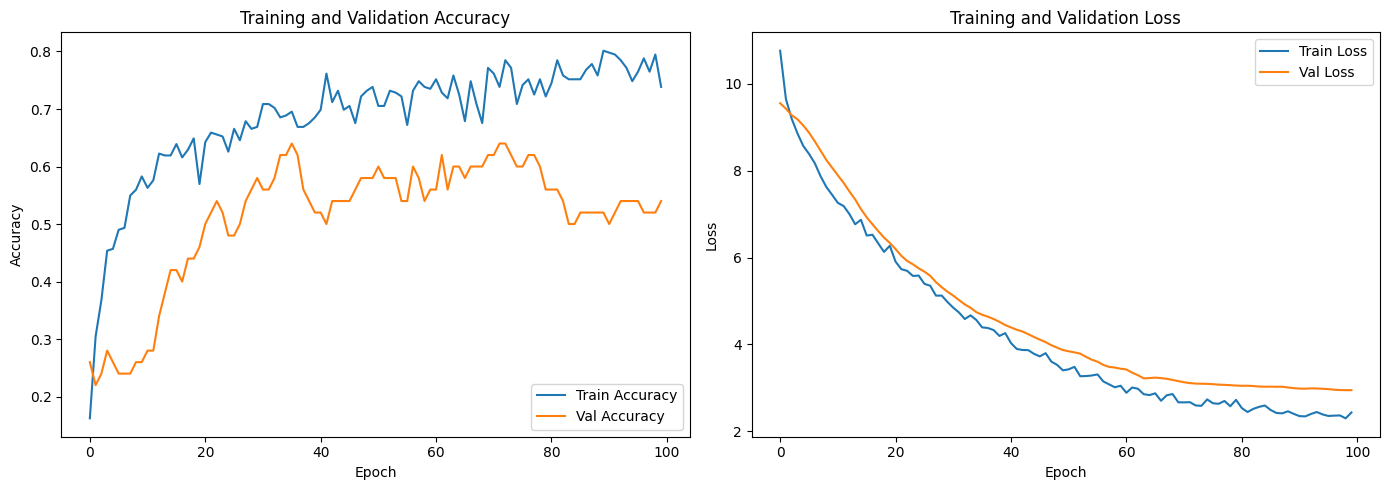

In [59]:
import matplotlib.pyplot as plt
epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Train Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Val Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.6400 - loss: 2.9278
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.6400 - loss: 2.9278
Test Loss: 2.9278
Test Accuracy: 0.6400
Test Loss: 2.9278
Test Accuracy: 0.6400
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
                      precision    recall  f1-score   support

        Alan_Rickman       0.80      0.80      0.80         5
       Bonnie_Wright       0.50      0.40      0.44         5
    Daniel_Radcliffe       0.80      0.80      0.80         5
         Emma_Watson       0.33      0.40      0.36         5
        Evanna_Lynch       0.60      0.60      0.60         5
Helena_Bonham_Carter       0.67      0.80      0.73         5
        Maggie_Smith       0.50      0.80      0.62         5
      Michael_Gambon       0.80      0.80      0.80         5
        Rupert_Grint       0.75      0.60      0.67         5
          Tom_Felton       1.00      0.40      0.57         5

            

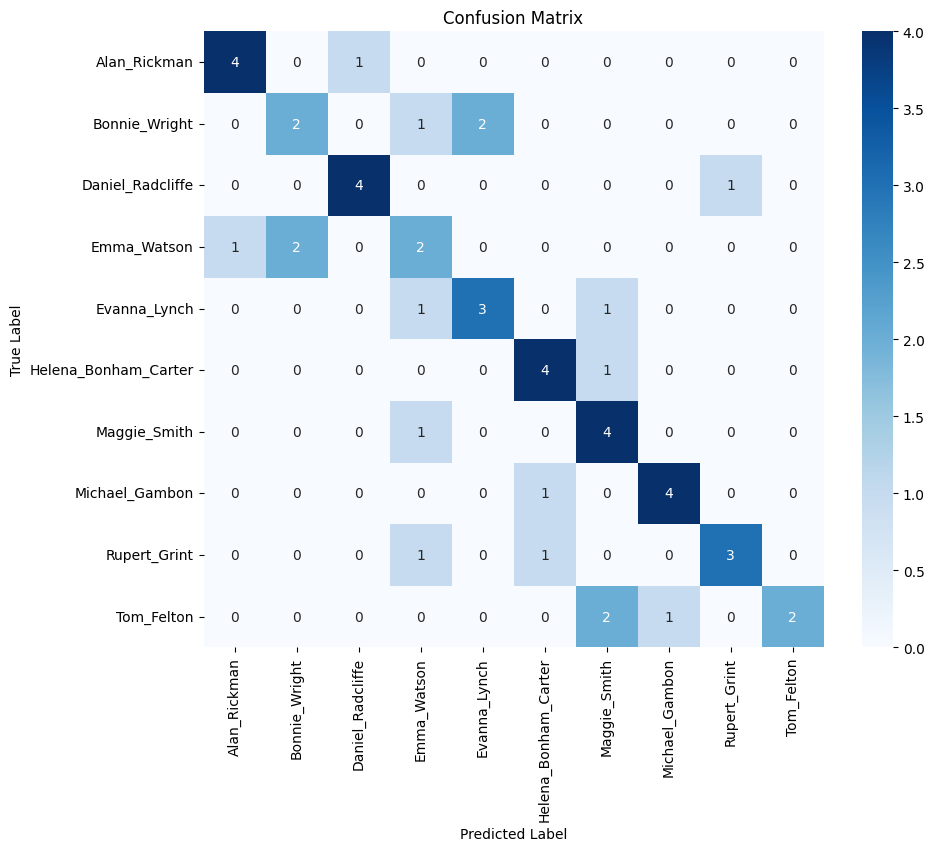

In [60]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate model on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

# Get true labels and predictions
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## 6. Predict on New Images
Use the unified preprocessing pipeline for new images and predict with the trained model.

In [73]:
def create_predict_folder():
    predict_dir = os.path.join('data', 'predict')
    if os.path.exists(predict_dir):
        shutil.rmtree(predict_dir)
    os.makedirs(predict_dir, exist_ok=True)
    test_dir = os.path.join('data', 'test')
    source_dir = os.path.join('data', 'source')
    actors = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
    for actor in actors:
        test_actor_dir = os.path.join(test_dir, actor)
        source_actor_dir = os.path.join(source_dir, actor)
        predict_actor_dir = os.path.join(predict_dir, actor)
        os.makedirs(predict_actor_dir, exist_ok=True)
        for img_name in os.listdir(test_actor_dir):
            src_img_path = os.path.join(source_actor_dir, img_name)
            dst_img_path = os.path.join(predict_actor_dir, img_name)
            if os.path.exists(src_img_path):
                shutil.copy2(src_img_path, dst_img_path)
    print('Predict folder created and populated.')

create_predict_folder()

Predict folder created and populated.


In [4]:
import tempfile
import shutil
from tensorflow.keras.utils import image_dataset_from_directory

def predict_with_dataset_pipeline(img_path, model, class_names):
    # Create a temporary directory and save the preprocessed image
    with tempfile.TemporaryDirectory() as tmp_dir:
        actor_dir = os.path.join(tmp_dir, 'actor')
        os.makedirs(actor_dir, exist_ok=True)
        # Preprocess and save image as done in preprocessing
        img_np = preprocess_image(img_path)
        if img_np is None:
            print('No face detected or multiple faces found.')
            return
        img_pil = Image.fromarray(img_np.astype('uint8'))
        if img_pil.mode == 'F':
            img_pil = img_pil.convert('L')
        img_pil.save(os.path.join(actor_dir, 'img.jpg'), format='JPEG')
        # Load image using tf.keras.utils.image_dataset_from_directory
        ds = image_dataset_from_directory(tmp_dir, labels=None, batch_size=1, image_size=(224, 224), shuffle=False)
        img_batch = next(iter(ds))
        pred_probs = model.predict(img_batch)
        sorted_indices = np.argsort(pred_probs[0])[::-1]
        sorted_scores = [(class_names[j], pred_probs[0][j]) for j in sorted_indices]
        for c, p in sorted_scores:
            print(f'{c}: {p:.4f}')

In [9]:
import os
import shutil
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from PIL import Image
import contextlib
import sys
import io
import tempfile
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import load_model

# Actor to character mapping
actor_to_character = {
    "Daniel_Radcliffe": "Harry Potter",
    "Emma_Watson": "Hermione Granger",
    "Rupert_Grint": "Ron Weasley",
    "Maggie_Smith": "Minerva McGonagall",
    "Michael_Gambon": "Albus Dumbledore",
    "Bonnie_Wright": "Ginny Weasley",
    "Alan_Rickman": "Severus Rogue",
    "Helena_Bonham_Carter": "Bellatrix Lestrange",
    "Tom_Felton": "Drago Malfoy",
    "Evanna_Lynch": "Luna Lovegood"
}

# Load trained model from file
model = load_model('best_mobilenetv2.keras')

# Interactive prediction UI
predict_dir = os.path.join('data', 'predict')
actors = [d for d in os.listdir(predict_dir) if os.path.isdir(os.path.join(predict_dir, d))]
actor_dropdown = widgets.Dropdown(options=actors, description='Actor:')
photo_dropdown = widgets.Dropdown(options=[], description='Photo:')
predict_button = widgets.Button(description='Predict', button_style='success')
output_box = widgets.Output()
img_box = widgets.Output()

# Update photo dropdown when actor changes
def update_photos(*args):
    actor = actor_dropdown.value
    actor_dir = os.path.join(predict_dir, actor)
    photos = [f for f in os.listdir(actor_dir) if os.path.isfile(os.path.join(actor_dir, f))]
    photo_dropdown.options = photos
actor_dropdown.observe(update_photos, names='value')
update_photos()

# Display selected image (fill box, keep aspect ratio)
def show_image(*args):
    img_box.clear_output()
    actor = actor_dropdown.value
    photo = photo_dropdown.value
    if actor and photo:
        img_path = os.path.join(predict_dir, actor, photo)
        with img_box:
            img = Image.open(img_path)
            # Set box size
            box_size = (160, 160)
            # Create white background
            bg = Image.new('RGB', box_size, (255,255,255))
            # Resize image to fit box, keep aspect ratio
            img.thumbnail(box_size, Image.LANCZOS)
            # Center image in box
            x = (box_size[0] - img.width) // 2
            y = (box_size[1] - img.height) // 2
            bg.paste(img, (x, y))
            display(bg)
photo_dropdown.observe(show_image, names='value')

# Suppress stdout context manager
def suppress_stdout():
    return contextlib.redirect_stdout(io.StringIO())

# Predict and display results
def on_predict_clicked(b):
    output_box.clear_output()
    actor = actor_dropdown.value
    character = actor_to_character.get(actor, actor)
    photo = photo_dropdown.value
    img_path = os.path.join(predict_dir, actor, photo)
    with output_box:
        # Run prediction and capture top 3
        with tempfile.TemporaryDirectory() as tmp_dir:
            actor_dir = os.path.join(tmp_dir, 'actor')
            os.makedirs(actor_dir, exist_ok=True)
            img_np = preprocess_image(img_path)
            if img_np is None:
                display(HTML(f'<b style="color:red">No face detected or multiple faces found.</b>'))
                return
            img_pil = Image.fromarray(img_np.astype('uint8'))
            if img_pil.mode == 'F':
                img_pil = img_pil.convert('L')
            img_pil.save(os.path.join(actor_dir, 'img.jpg'), format='JPEG')
            # Suppress TensorFlow loading output
            with suppress_stdout():
                ds = image_dataset_from_directory(tmp_dir, labels=None, batch_size=1, image_size=(224, 224), shuffle=False)
            img_batch = next(iter(ds))
            with suppress_stdout():
                pred_probs = model.predict(img_batch)
            sorted_indices = np.argsort(pred_probs[0])[::-1]
            sorted_scores = [(class_names[j], pred_probs[0][j]) for j in sorted_indices]
            # Display results
            top_pred = sorted_scores[0]
            top3 = sorted_scores[:3]
            html = f"""
            <div style='margin-top:10px;'>
                <b>Top Prediction:</b> {actor_to_character.get(top_pred[0], top_pred[0])} <span style='color: #007acc'>({top_pred[1]:.4f})</span><br>
                <b>Top 3 Predictions:</b>
                <ol style='margin-top:5px;'>
            """
            for c, p in top3:
                html += f"<li>{actor_to_character.get(c, c)} <span style='color: #007acc'>({p:.4f})</span></li>"
            html += "</ol></div>"
            display(HTML(html))
predict_button.on_click(on_predict_clicked)

ui = widgets.VBox([
    widgets.HTML('<h3>Face Recognition Prediction</h3>'),
    widgets.HBox([actor_dropdown, photo_dropdown, predict_button]),
    img_box,
    output_box
])
display(ui)



Training with optimizer: Adadelta
Test accuracy: 0.0600, Test loss: 9.9935

Training with optimizer: Adagrad
Test accuracy: 0.0600, Test loss: 9.9935

Training with optimizer: Adagrad
Test accuracy: 0.3400, Test loss: 9.1479

Training with optimizer: RMSProp
Test accuracy: 0.3400, Test loss: 9.1479

Training with optimizer: RMSProp
Test accuracy: 0.5400, Test loss: 4.6306

Training with optimizer: Adam
Test accuracy: 0.5400, Test loss: 4.6306

Training with optimizer: Adam
Test accuracy: 0.5200, Test loss: 5.3329

Training with optimizer: SGD
Test accuracy: 0.5200, Test loss: 5.3329

Training with optimizer: SGD
Test accuracy: 0.4600, Test loss: 8.5764

Training with optimizer: AdamW
Test accuracy: 0.4600, Test loss: 8.5764

Training with optimizer: AdamW
Test accuracy: 0.5400, Test loss: 5.2315
Test accuracy: 0.5400, Test loss: 5.2315



Training with optimizer: Adadelta
Test accuracy: 0.0600, Test loss: 9.9935

Training with optimizer: Adagrad
Test accuracy: 0.0600, Test loss: 9.9935

Training with optimizer: Adagrad
Test accuracy: 0.3400, Test loss: 9.1479

Training with optimizer: RMSProp
Test accuracy: 0.3400, Test loss: 9.1479

Training with optimizer: RMSProp
Test accuracy: 0.5400, Test loss: 4.6306

Training with optimizer: Adam
Test accuracy: 0.5400, Test loss: 4.6306

Training with optimizer: Adam
Test accuracy: 0.5200, Test loss: 5.3329

Training with optimizer: SGD
Test accuracy: 0.5200, Test loss: 5.3329

Training with optimizer: SGD
Test accuracy: 0.4600, Test loss: 8.5764

Training with optimizer: AdamW
Test accuracy: 0.4600, Test loss: 8.5764

Training with optimizer: AdamW
Test accuracy: 0.5400, Test loss: 5.2315
Test accuracy: 0.5400, Test loss: 5.2315


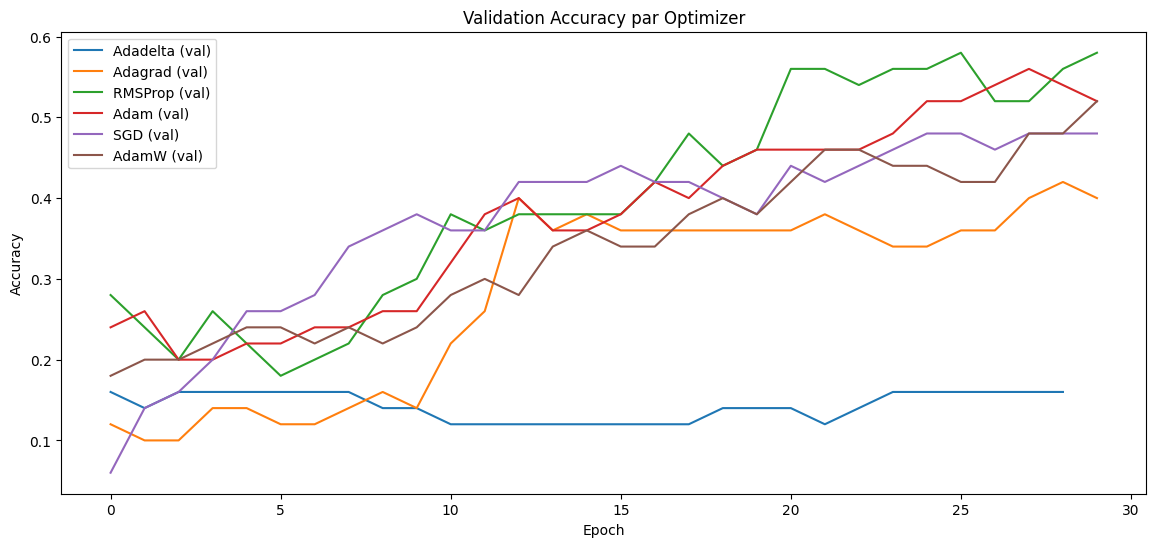


Training with optimizer: Adadelta
Test accuracy: 0.0600, Test loss: 9.9935

Training with optimizer: Adagrad
Test accuracy: 0.0600, Test loss: 9.9935

Training with optimizer: Adagrad
Test accuracy: 0.3400, Test loss: 9.1479

Training with optimizer: RMSProp
Test accuracy: 0.3400, Test loss: 9.1479

Training with optimizer: RMSProp
Test accuracy: 0.5400, Test loss: 4.6306

Training with optimizer: Adam
Test accuracy: 0.5400, Test loss: 4.6306

Training with optimizer: Adam
Test accuracy: 0.5200, Test loss: 5.3329

Training with optimizer: SGD
Test accuracy: 0.5200, Test loss: 5.3329

Training with optimizer: SGD
Test accuracy: 0.4600, Test loss: 8.5764

Training with optimizer: AdamW
Test accuracy: 0.4600, Test loss: 8.5764

Training with optimizer: AdamW
Test accuracy: 0.5400, Test loss: 5.2315
Test accuracy: 0.5400, Test loss: 5.2315


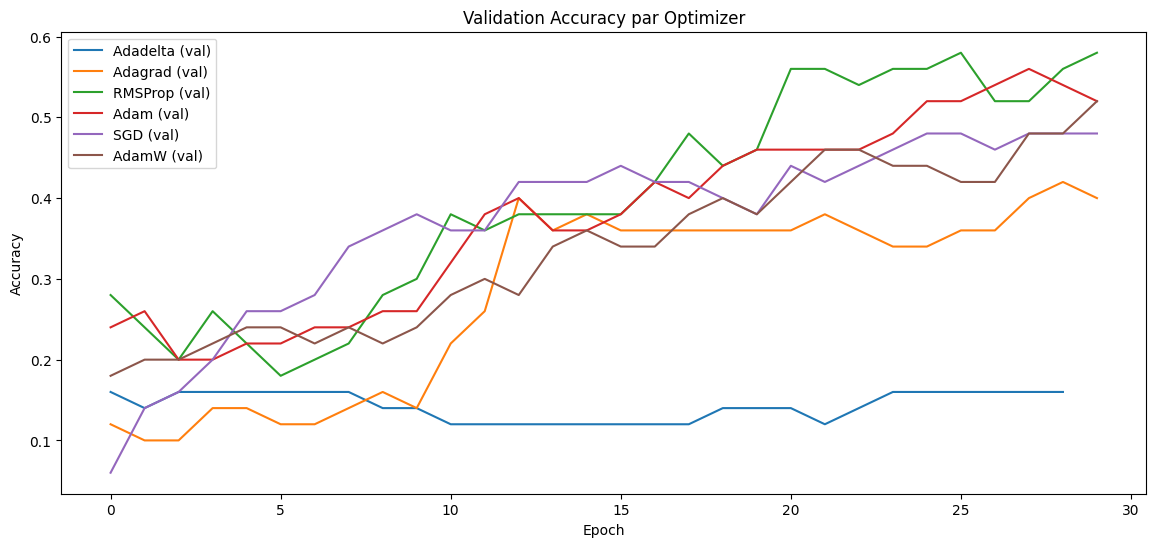

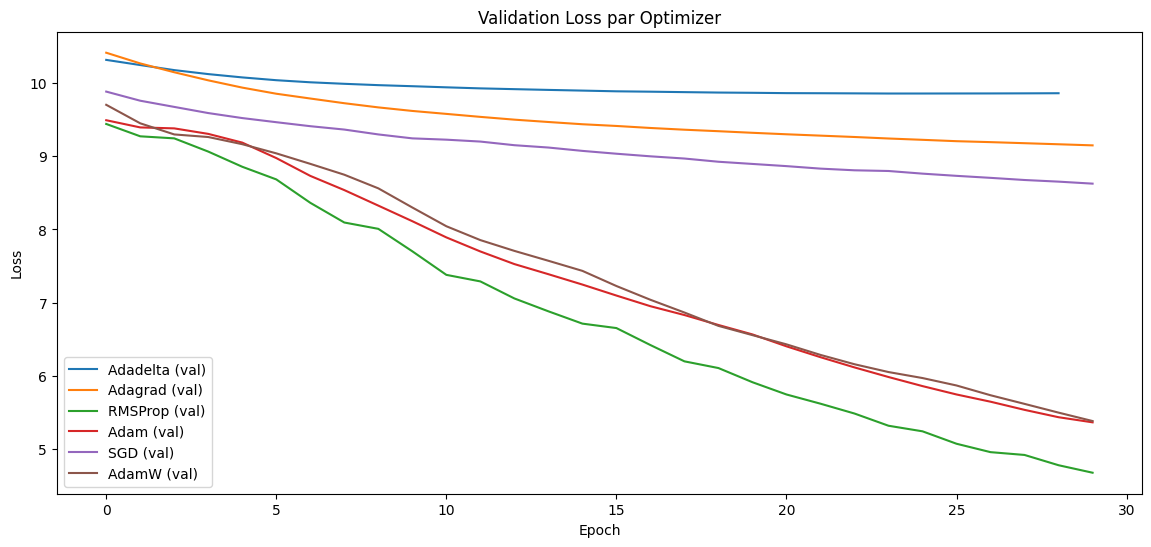

          Test Accuracy  Test Loss
Adadelta           0.06   9.993534
Adagrad            0.34   9.147862
RMSProp            0.54   4.630617
Adam               0.52   5.332907
SGD                0.46   8.576416
AdamW              0.54   5.231528


In [79]:
# Benchmark des optimizers sur le CNN Harry Potter
import tensorflow as tf
from tensorflow.keras.optimizers import Adadelta, Adagrad, RMSprop, Adam, SGD, AdamW
try:
    from adan import Adan  # pip install adan
except ImportError:
    Adan = None
import matplotlib.pyplot as plt

optimizers = {
    'Adadelta': Adadelta(),
    'Adagrad': Adagrad(),
    'RMSProp': RMSprop(),
    'Adam': Adam(),
    'SGD': SGD(),
    'AdamW': AdamW(),
}
if Adan:
    optimizers['Adan'] = Adan()

results = {}
for name, opt in optimizers.items():
    print(f"\nTraining with optimizer: {name}")
    # Recréer le modèle à chaque fois
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False
    inputs = base_model.input
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(len(class_names), activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ]
    history = model.fit(train_ds_aug, validation_data=val_ds, epochs=30, callbacks=callbacks, verbose=0)
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    results[name] = {
        'history': history.history,
        'test_loss': test_loss,
        'test_acc': test_acc
    }
    print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

# Affichage des courbes comparatives
plt.figure(figsize=(14, 6))
for name, res in results.items():
    plt.plot(res['history']['val_accuracy'], label=f'{name} (val)')
plt.title('Validation Accuracy par Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
for name, res in results.items():
    plt.plot(res['history']['val_loss'], label=f'{name} (val)')
plt.title('Validation Loss par Optimizer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Tableau récapitulatif
import pandas as pd
df = pd.DataFrame({name: {'Test Accuracy': res['test_acc'], 'Test Loss': res['test_loss']} for name, res in results.items()}).T
print(df)


In [81]:
# save results dict as json

import json

with open('optimizer_benchmark_results.json', 'w') as f:
    json.dump(results, f, indent=4)